In [1]:
import sys
import cv2
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from GTSRBNet import GTSRBNet
from GTSRBDataset import GTSRBDataset
from matplotlib import pyplot as plt
from torchvision.utils import save_image
from PIL import Image
import torchvision.transforms.functional as TF

In [2]:
root = ''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))])

validset = GTSRBDataset('valid_us.npz', transform=transform)
validloader = torch.utils.data.DataLoader(validset, batch_size=256,
                                          shuffle=True, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = GTSRBNet()
model.to(device)

classes = []
with open(root + 'class_semantics.txt') as f:
    for line in f:
        classes.append(line.strip())

checkpoint = torch.load('checkpoint_us.tar',map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

GTSRBNet(
  (conv1_1): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv2_1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2_1): Dropout2d(p=0.5, inplace=False)
  (conv3_1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3_2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool3_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3_1): Dropout2d(p=0.5, inplace=False)
  (conv4_1): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4_2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool4_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop4_1): Dropout2d(p=0.5, inplace=False)
  (fc5_1): Linear(in_features=2048, out_features=1024,

In [3]:
#Helper Functions
def imshow(img):
    img = img + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
def saveim(img, name):
    save_image(img, name)
def readim(name):
    image = Image.open(name)
    x = TF.to_tensor(image)
    tform = transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
    x = tform(x)
    x.unsqueeze_(0)
    return x
def stack(w,size):
    dim = len(torch.flatten(w))
    if dim == size:
        return w
    ide = torch.eye(dim, requires_grad=True, dtype=torch.float, device=device)
    zer = torch.zeros([1,dim], requires_grad=True, dtype=torch.float, device=device)

    n = size // dim
    m = size % dim
    nsum = torch.zeros([1,1,size,1], requires_grad=True, dtype=torch.float, device=device)
    ides = torch.cat(n*[ide])
    if m != 0:
        zers = torch.cat(m*[zer])
        mat = torch.cat([ides,zers])
    else:
        mat = ides
    nsum = nsum + torch.matmul(mat,w)
    if m == 0:
        return nsum
    t = []
    for i in range(m):
        t.append(torch.tensor([1 if x == i else 0 for x in range(dim)],requires_grad=True, dtype=torch.float, device=device))

    mat2 = torch.cat([torch.cat(dim*n*[zer]),torch.stack(t)])
    nsum = nsum + torch.matmul(mat2,w)
    return nsum
def gamma_correction(img, factor):
    return ((img+0.5)**factor)-0.5

Stop
14


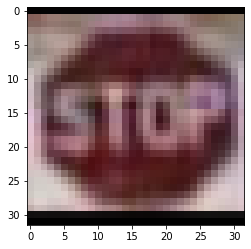

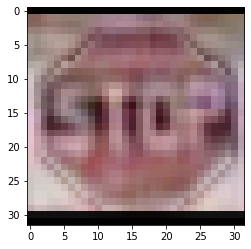

torch.return_types.max(
values=tensor([1.], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([14], device='cuda:0')) torch.return_types.max(
values=tensor([0.3621], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([12], device='cuda:0'))


In [35]:
classidx = 14 #or 34 for left turn
targidx = 13 #yield
o_class = classes[classidx]
print(o_class)
print(classidx)
cls = 'stop' #change to lturn for left turn

input_im = readim("images/original/{}.png".format(cls))
xadv = readim("images/adversarial/{}adv36.png".format(cls))
input_im = input_im.cuda()
xadv = xadv.cuda()
out = model(input_im)
outadv = model(xadv)
imshow(input_im[0].cpu())
imshow(xadv[0].cpu())

lay2 = torch.nn.Softmax(dim=1)
prob = lay2(out)
prob2 = lay2(outadv)
print(prob.max(1), prob2.max(1))


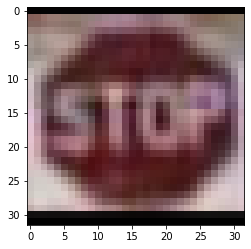

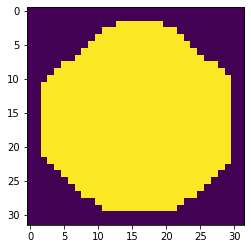

In [11]:
def get_object_mask(input_image):
    test = np.uint8((input_image+0.5).numpy()*255).transpose((1,2,0))
    test[0][:] = test[1][:]
    test[-1][:] = test[-3][:]
    test[-2][:] = test[-3][:]
    #print(test[-3][:])
    gray = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(test, (3, 3), 0)
    edged = cv2.Canny(blurred, 0, 255)   
    #imgplot = plt.imshow(test)
    #plt.show()
    #imshow(input_image[0])
    #applying closing function
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)    #finding_contours
    (cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)    
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        cv2.drawContours(closed, [approx], -1, (0, 255, 0), 2)    
    th, im_th = cv2.threshold(closed, 220, 255, cv2.THRESH_BINARY_INV);    
    h, w = im_th.shape[:2]
    im_floodfill = im_th.copy()
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 0);    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)    # Combine the two images to get the foreground.
    im_out = im_th ^ im_floodfill_inv
    return im_out
imshow(input_im[0].cpu())
imgplot = plt.imshow(get_object_mask(input_im[0].cpu()))
plt.show()

In [37]:
# The input time signal
sz = 36
w = torch.rand([1,1,sz,1], requires_grad=True, dtype=torch.float, device=device)

#Does not work since no useful gradients
#Aw = torch.rand([1], requires_grad=True, dtype=torch.float, device=device) #amplitude and frequency
#sample = torch.linspace(0, 4, sz, dtype=torch.float, device=device)  #Sampling rate, do the math to get this
#w = torch.sin(100*Aw[0]*sample).view([1,1,sz,1]) #Sample the sine wave

mask = torch.tensor(get_object_mask(input_im[0].cpu()))
mask = mask / torch.max(mask)
mask = mask.cuda()
#The shutter function is encoded into the convolution layer
lay = torch.nn.Conv1d(1,1,5)
lay.to(device)

#Manually setting the weights and bias so the  shutter acts as a box filter
lay.weight.data = torch.full([1,1,5,1], .2, requires_grad=True, dtype=torch.float, device=device)
lay.bias.data = torch.zeros(1, requires_grad=True, dtype=torch.float, device=device)

#Target and original class labels
target = torch.tensor([targidx], dtype=torch.long, device=device) #Yield
orig = torch.tensor([classidx], dtype=torch.long, device=device)


lr = 1e-1
n_epochs = 1000
optimizer = optim.SGD([w], lr=lr)
loss_fn = nn.CrossEntropyLoss()

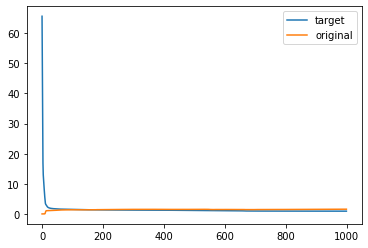

In [38]:
targloss = []
origloss = []
for epoch in range(n_epochs):
    
    # Compute g(y) to get X_adv
    #gy = lay(ft)    
    #w = torch.tanh(gy)
    
    oot = stack(w,36)
    new_w = .5 * (torch.tanh(oot) + 1)
    #new_w = .5 * (oot + 1) #Method using Sin, does not work, no gradients
    gy = lay(new_w)             #Convolution of ft and the shutter
    gy_mask = gy * mask
    #gy_mask = gy_mask + (1 - mask)
    inp = (input_im + .5) + (gamma_correction(input_im[0], 0.4) - input_im)*(gy_mask) - 0.5         #gy is broadcasted to match the shape of input_im
    out = model(inp)
    
    #Calculate Loss
    loss = loss_fn(out, target)
    targloss.append(loss.data)
    origloss.append(loss_fn(out,orig))
    loss.backward(retain_graph=True)
    
    
    optimizer.step()
    
    optimizer.zero_grad()
    
plt.plot(targloss, label="target")
plt.plot(origloss, label="original")
plt.legend()
plt.show()


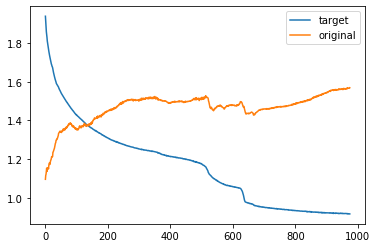

In [39]:
plt.plot(targloss[25:], label="target")
plt.plot(origloss[25:], label="original")
plt.legend()
plt.show()

In [40]:
lay2 = torch.nn.Softmax(dim=1)
prob = lay2(out)
#prob2 = lay2(out2)
prob.max(1)


torch.return_types.max(
values=tensor([0.3999], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([13], device='cuda:0'))

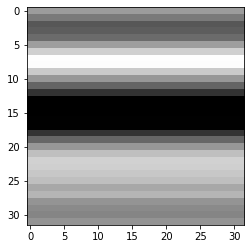

In [41]:
test = torch.ones([1,3,32,32], device=device)
test = test * (gy)
imshow(test[0].detach().cpu() - .5)

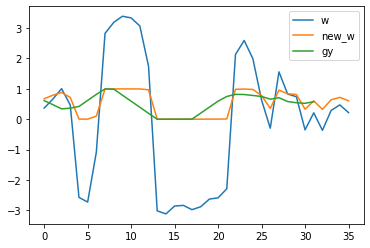

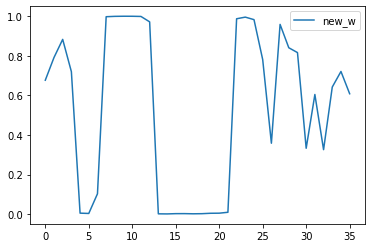

In [42]:
plt.plot(torch.flatten(w).detach().cpu(), label="w")
plt.plot(torch.flatten(new_w).detach().cpu(), label="new_w")
plt.plot(torch.flatten(gy).detach().cpu(),label="gy")
plt.legend()
plt.show()
plt.plot(torch.flatten(new_w).detach().cpu(), label="new_w")
plt.legend()
plt.show()

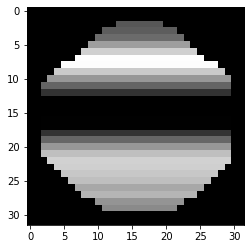

In [43]:
test = torch.ones([1,3,32,32], device=device)
test = test * (gy_mask )
imshow(test[0].detach().cpu() - .5)

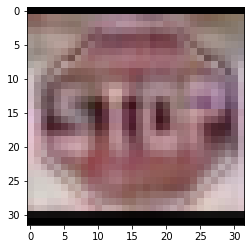

In [44]:
imshow(inp[0].detach().cpu())
saveim(inp[0].detach().cpu() + 0.5, "images/adversarial/{}adv{}.png".format(cls,sz))

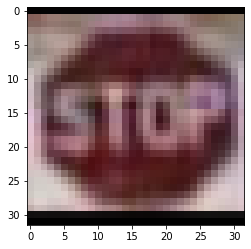

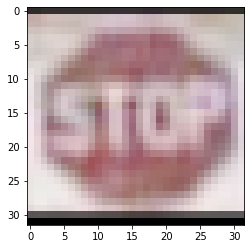

In [45]:
imshow(((input_im[0].cpu()+.5) ) - 0.5)
imshow(gamma_correction(input_im[0].cpu(), 0.4))
saveim(input_im + 0.5, "images/original/{}.png".format(cls))

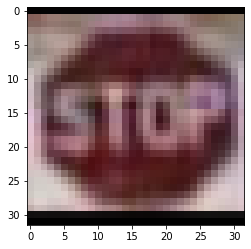

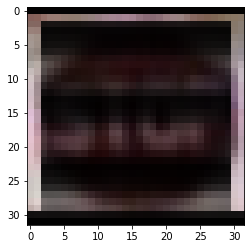

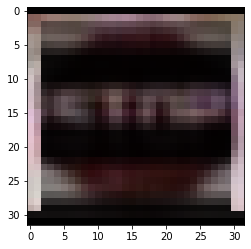

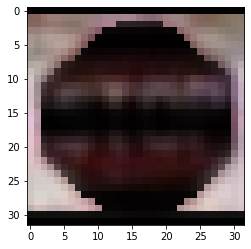

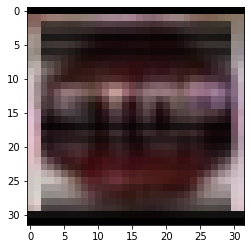

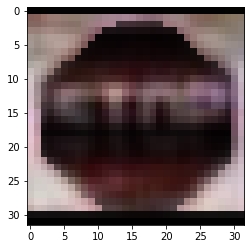

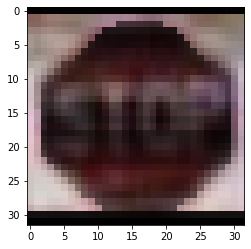

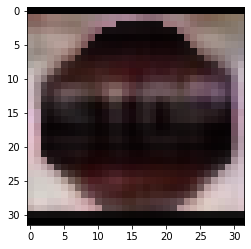

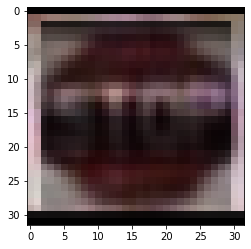

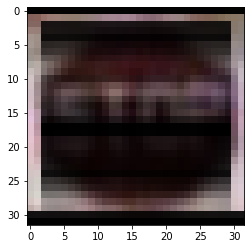

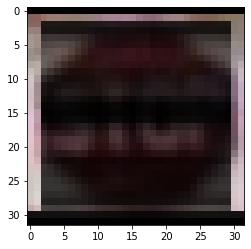

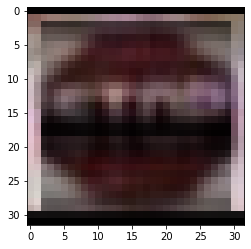

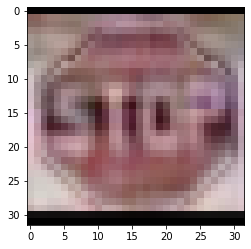

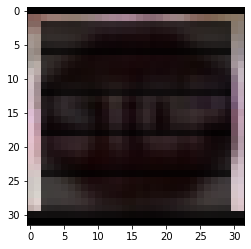

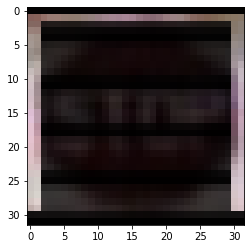

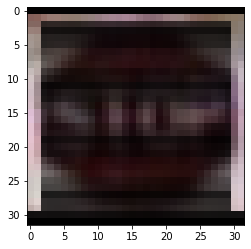

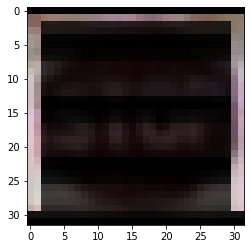

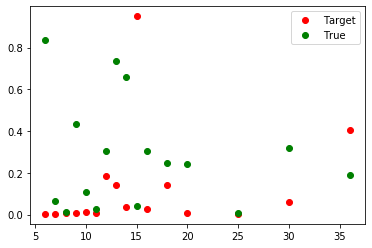

In [46]:
l = []
conf = []
true = []
lay2 = torch.nn.Softmax(dim=1)
input_im = readim("images/original/{}.png".format(cls))
input_im = input_im.cuda()
out = model(input_im)
trueprob = lay2(out)
imshow(input_im[0].cpu())

img_path = "images/adversarial/"
file_names = [fn for fn in os.listdir(img_path) if fn[:len(cls)] == cls]
for i in file_names:
    l.append(int(i[len(cls)+3:-4]))
    xadv = readim("images/adversarial/{}".format(i)).cuda()
    out = model(xadv)
    imshow(xadv[0].cpu())
    prob = lay2(out)
    conf.append(prob[0][target[0].item()])
    true.append(prob[0][classidx])
plt.plot(l,conf,"ro", label="Target")
plt.plot(l,true, "go", label="True")
plt.legend()
plt.show()




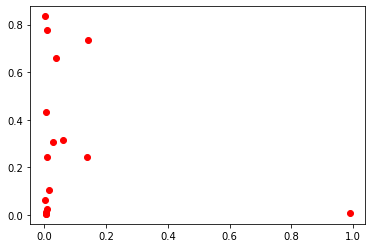

In [87]:
plt.plot(conf,true, "ro")
plt.show()

In [23]:
mask

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)

In [36]:
prob2

tensor([[1.1539e-03, 3.0137e-02, 3.3850e-03, 1.2973e-03, 6.3957e-04, 2.6703e-03,
         4.8636e-03, 1.0070e-03, 1.3821e-03, 6.1669e-03, 2.6890e-04, 3.2887e-04,
         3.6214e-01, 2.8645e-01, 2.3646e-01, 4.8803e-03, 4.8436e-04, 1.7555e-03,
         2.6230e-03, 7.0502e-05, 7.3056e-04, 5.4972e-04, 7.1205e-05, 6.6356e-04,
         3.6296e-05, 1.9793e-02, 8.5721e-04, 4.7327e-05, 1.2169e-03, 3.0986e-03,
         6.1956e-05, 4.6250e-04, 5.9711e-03, 6.7628e-04, 3.9804e-04, 1.1411e-03,
         1.0215e-04, 5.1582e-04, 2.7446e-03, 9.8064e-05, 8.6587e-03, 3.8183e-03,
         1.2529e-04]], device='cuda:0', grad_fn=<SoftmaxBackward>)